In [2]:
from functools import reduce
from collections import defaultdict
import re
from pathlib import Path

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from bs4.element import Tag as BSTagType
import pickle
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
TRUNCATE_TO = 99
DISCLOSURE_FILENAME_COL_NAME = 'disclosureId'
RELEVANT_FIELDS = [
    'organizationName',
    'zip',
    'registrantGeneralDescription',
    'clientName',
    'clientZip',
    'clientGeneralDescription',
    'specific_issues',
    'reportYear',
    'reportType',
    'effectiveDate'
]
DATA_DIR = '../../data/'

def find(condition, iterable):
    for item in iterable:
        if condition(item):
            return item
    return None

def child_with_name(name, children):
   return find(lambda child : child.name == name, children)

def elements_among(iterable):
    return [
        child for child in iterable
        if type(child) == BSTagType
    ]

def second_level_nodes(path):
    with open(path) as f:
        disclosure = BeautifulSoup(f, 'lxml-xml')

    if len(list(disclosure.children)) == 0: # first element was XML doc declaration
        with open(path) as f:
            next(f) # so skip it
            disclosure = BeautifulSoup(f, 'lxml-xml') # and use the second

    if 'children' in dir(list(disclosure.children)[0]):
        children = list(disclosure.children)[0].children
    else: # has XML-stylesheet declaration element
        children = list(disclosure.children)[1].children # skip it
    
    return elements_among(children)

def row_from_path(path):
    disclosure_children = second_level_nodes(path)
    organization_name_node = child_with_name('organizationName', disclosure_children)
    client_name_node = child_with_name('clientName', disclosure_children)
    effective_date_node = child_with_name('effectiveDate', disclosure_children)
    lobbyists_node = child_with_name('lobbyists', disclosure_children)
    alis_node = child_with_name('alis', disclosure_children)

#     print(type(next(alis_node.children)))

    return {
        'organization_name': organization_name_node and organization_name_node.text,
        'client_name': client_name_node and client_name_node.text,
        'effective_date': effective_date_node and effective_date_node.text,
        'lobbyists': len(
            [
                lobbyist_node
                for lobbyist_node
                in ((lobbyists_node and lobbyists_node.children) or [])
                if (
                    type(lobbyist_node) == BSTagType
                ) and (
                    re.match('\S', lobbyist_node.lobbyistFirstName.text) and
                    re.match('\S', lobbyist_node.lobbyistLastName.text)
                )
            ]
        ),
        'alis': ','.join([
            ali_node.text
            for ali_node
            in elements_among((alis_node and alis_node.children) or [])
            if not re.match('^\s*$', ali_node.text)
        ])
        
    }
re.match
def collect_fields(paths):
    fields = set([DISCLOSURE_FILENAME_COL_NAME])
    for path in paths:
        for field in row_from_path(path).keys():
            fields.add(field)
    return fields

def add_row(collection, fields, row, filename):
    if not row:
        print('NO DATA ROW')
        return
    for field in fields:
        if field == DISCLOSURE_FILENAME_COL_NAME:
            collection[field].append(filename)
        elif field in row.keys():
            collection[field].append(row[field])
        else:
            collection[field].append(None)

def filename_from_path(path):
    return re.search('\/([^\/]+)\.xml$', str(path))[1] # filename without extension

In [40]:
disclosure_subdirs = Path('../../data/lobbying_disclosures/').glob('*')
disclosure_paths = reduce(
    lambda collection, subdir : collection + list(Path(subdir).glob('*')),
    disclosure_subdirs,
    []
)

trunc_paths = disclosure_paths[:TRUNCATE_TO]

# fields = collect_fields(trunc_paths)

fields = [
    DISCLOSURE_FILENAME_COL_NAME,
    'organization_name',
    'client_name',
    'effective_date',
    'lobbyists',
    'alis'
]

disclosures_dict = {field: [] for field in fields}
times = 0
for path in trunc_paths:
    if(times % 1000 == 0):
        print(times)
    times += 1
    try:
        add_row(
            disclosures_dict,
            fields,
            row_from_path(path),
            filename_from_path(path)
        )
    except:
        print(f'error: {path}')


In [4]:
disclosures = pd.DataFrame(disclosures_dict)
disclosures = disclosures.set_index(DISCLOSURE_FILENAME_COL_NAME)

In [54]:
# typo
disclosures.effective_date = disclosures.effective_date.replace('03/031/2008', '03/31/2008')

# cast
disclosures.effective_date = pd.to_datetime(disclosures.effective_date)

In [85]:
disclosures['client_name'] = disclosures['client_name'].str.strip()
disclosures['organization_name'] = disclosures['organization_name'].str.strip()

In [112]:
disclosures.effective_date.max()

Timestamp('2019-02-01 00:00:00')

In [114]:
(20*12)

240

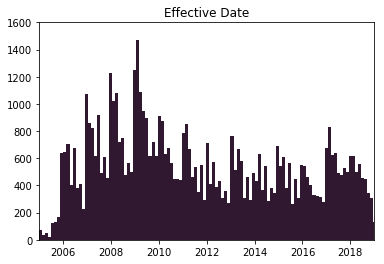

In [17]:
plt.hist(
    disclosures.effective_date,
    bins=2688,
    color='#301830'
)
plt.title('Effective Date');
plt.axis(
    xmin=datetime(2005, 1, 1),
    xmax=datetime(2019, 1, 1),
    ymin=0,
    ymax=1600
);

In [104]:
# cull where client name missing
disclosures = disclosures[ ~(
    (disclosures.client_name.isnull()) |
    (disclosures.organization_name.isnull()) | 
    (disclosures.organization_name == '') |
    (disclosures.lobbyists == 0)
)]

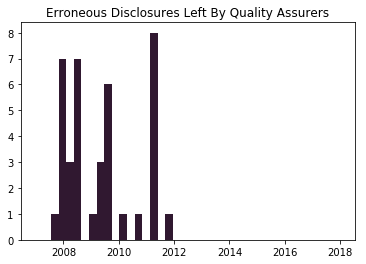

In [66]:
plt.hist(
    qa_rows.effective_date,
    bins=40,
    color='#301830',
    range=[
        datetime(2007, 1, 1),
        datetime(2018, 1, 1)        
    ]
)
plt.title('Erroneous Disclosures Left By Quality Assurers');


In [67]:
# cull entries left in by QA
disclosures = disclosures[~ disclosures.organization_name.str.contains('QA')]

In [85]:
# junk entry
disclosures = disclosures[ ~(
    (disclosures.client_name == 'aaaddd') &
    (disclosures.organization_name == 'aaa')
)]

In [106]:
with open(f'{DATA_DIR}disclosures.pkl', 'wb') as file:
    pickle.dump(disclosures, file)

In [108]:
with open(f'{DATA_DIR}disclosures.pkl', 'rb') as file:
    disclosures = pickle.load(file)

In [109]:
len(disclosures)

70118